## Default of Credit Card Clients
### SVM 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
df_original = pd.read_excel("./input/default of credit card clients.xls",header=1)
df_original =df_original.rename({'PAY_0' : 'PAY_1','default payment next month':'default'},axis=1)
df = df_original.copy()
N_labels = [column for column in df_original.columns if column !='default']
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index , test_index in split.split(df,df.iloc[:,[2,-1]]):
    df_train, label_train= df[N_labels].loc[train_index],df.default[train_index]
    df_test, label_test= df[N_labels].loc[test_index], df.default[test_index]
    

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
class BasicTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,scale = 'log'):
        self.columns=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
       'USAGE_1', 'USAGE_2', 'USAGE_3', 'USAGE_4', 'USAGE_5',
       'DIFF_0', 'DIFF_1', 'DIFF_2', 'DIFF_3',
       'DIFF_4', 'log_LIMIT_BAL', 'log_BILL_AMT1', 'log_BILL_AMT2',
       'log_BILL_AMT3', 'log_BILL_AMT4', 'log_BILL_AMT5', 'log_BILL_AMT6',
       'log_PAY_AMT1', 'log_PAY_AMT2', 'log_PAY_AMT3', 'log_PAY_AMT4',
       'log_PAY_AMT5', 'log_PAY_AMT6', 'log_USAGE_1', 'log_USAGE_2',
       'log_USAGE_3', 'log_USAGE_4', 'log_USAGE_5', 'log_DIFF_0',
       'log_DIFF_1', 'log_DIFF_2', 'log_DIFF_3',
       'log_DIFF_4']
        self.log_columns=['log_LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'log_BILL_AMT1','log_BILL_AMT2', 'log_BILL_AMT3', 'log_BILL_AMT4', 'log_BILL_AMT5',
       'log_BILL_AMT6', 'log_PAY_AMT1', 'log_PAY_AMT2', 'log_PAY_AMT3',
       'log_PAY_AMT4', 'log_PAY_AMT5', 'log_PAY_AMT6', 'log_USAGE_1',
       'log_USAGE_2', 'log_USAGE_3', 'log_USAGE_4', 'log_USAGE_5',
       'log_DIFF_0', 'log_DIFF_1', 'log_DIFF_2', 'log_DIFF_3', 'log_DIFF_4']
        self.scale = scale 
    
    def fit(self,x=None , y = None):
        return self
    def log_pre (self,x):
        return np.log(1+abs(2*x))*np.sign(x)
    def log_pre_col (self,column):
        return column.map(lambda x:self.log_pre(x))
    
    def transform(self,df,y=None):
        #Usage
        df_usage = pd.DataFrame()
        df_usage['ID']=df.ID
        BILL = [column for column in df.columns if 'BILL' in column]
        PAY = [column for column in df.columns if 'PAY_AMT' in column]
        for i in range(5):
            df_usage[f"USAGE_{i+1}"] = df[BILL[i]]-(df[BILL[i+1]]-df[PAY[i]])
        #difference
        df_difference =pd.DataFrame()
        df_difference['ID'] = df.ID
        for i in range(5):
            df_difference[f"DIFF_{i}"] = df[BILL[i+1]]-df[PAY[i]]
        USAGE = [column for column in df_usage.columns if column !='ID']
        DIFF = [column for column in df_difference.columns if column !='ID']
        LIM =['LIMIT_BAL']
        ## Logarithmic Scaling attribute 
        df = pd.concat([df,df_usage.iloc[:,1:],df_difference.iloc[:,1:]],axis=1)
        df_log =pd.concat([df.ID,df[LIM+BILL+PAY+USAGE+DIFF].apply(self.log_pre_col,axis=0)],axis=1) #apply(function,axis=) map of those who use index/column as a index
        rename_dict = {}
        for i in df_log.iloc[:,1:].columns:
            rename_dict[i] = 'log_'+i
        df_log =df_log.rename(rename_dict,axis=1)
        self.BILL = BILL
        self.PAY =PAY
        self.DIFF = DIFF
        self.USAGE =USAGE
        df = pd.concat([df,df_log[[column for column in df_log.columns if column !='ID']]],axis=1)
        if self.scale == 'log':
            return df[self.log_columns].to_numpy()
        return df[self.columns].to_numpy()

In [3]:
for train_index , test_index in split.split(df_train,pd.concat([df_train.SEX,label_train],axis=1)):
     X_train, y_train= df_train.iloc[train_index],label_train.iloc[train_index]
     X_val, y_val = df_train.iloc[test_index], label_train.iloc[test_index]
#X_train ,y_train= df_train.iloc[:10,:] ,label_train.iloc[:10]

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.metrics import precision_score, recall_score


In [7]:
def pre_rec_score(y_train,y_pred):
    pre_score = precision_score(y_train,y_pred)
    print(f'precision : {pre_score}')
    rec_score = recall_score(y_train,y_pred)
    print(f'recall : {rec_score}')

## LinearSVC : most basic and fast

In [8]:
pipe = Pipeline([('base',BasicTransformer()),
                ('scaler',StandardScaler()),
                ('estimator',LinearSVC(max_iter = 10000,random_state=42))
                ])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
pre_rec_score(y_train,y_pred)

[[12772   370]
 [ 2934   799]]
precision : 0.6834901625320787
recall : 0.21403696758639165


## SVC : RGF kernel

In [10]:
pipe = Pipeline([('base',BasicTransformer()),
                ('scaler',MinMaxScaler()),
                ('estimator',SVC(random_state=42))
                ])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
pre_rec_score(y_train,y_pred)

[[12509   633]
 [ 2394  1339]]
precision : 0.6790060851926978
recall : 0.35869274042325205


## Standard scaler vs MinMax scaler

In [11]:
pipe = Pipeline([('base',BasicTransformer()),
                ('scaler',StandardScaler()),
                ('estimator',SVC(random_state=42))
                ])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
pre_rec_score(y_train,y_pred)

[[12615   527]
 [ 2389  1344]]
precision : 0.7183324425440941
recall : 0.3600321457272971


## SGDC

In [12]:
pipe = Pipeline([('base',BasicTransformer()),
                ('scaler',StandardScaler()),
                ('estimator',SGDClassifier(random_state=42))
                ])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
pre_rec_score(y_train,y_pred)

[[12532   610]
 [ 2644  1089]]
precision : 0.6409652736904061
recall : 0.29172247522100186


## SVC: sigmoid

In [16]:
pipe = Pipeline([('base',BasicTransformer()),
                ('scaler',StandardScaler()),
                ('estimator',SVC(kernel='sigmoid',random_state=42))
                ])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
pre_rec_score(y_train,y_pred)

[[10782  2360]
 [ 2408  1325]]
precision : 0.35956580732700133
recall : 0.3549424055719261


In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
# pipe = Pipeline([('base',BasicTransformer()),
#                 ('scaler',StandardScaler()),
#                 ('est',SVC(random_state=42))
#                 ])
# param_grid = {
#     'est__C':[0.0005,0.001,0.01,0.1,0.4,0.8,1.0],
#     #'est__kernel' : ['linear','poly','rbf','sigmoid'],
#     'est__kernel' : ['linear','poly','rbf','sigmoid'],
#     'est__degree' : [3,5],
#     'est__gamma' : ['scale','auto',5],
#     'est__coef0' : [0,0.5,1],
# }
# search = GridSearchCV(pipe, 
#                       scoring='recall',
#                       verbose=2,
#                       param_grid=param_grid, n_jobs=2)
# search.fit(X_train,y_train)
# print(search.cv_results_)
# print(search.best_estimator_)
# print(search.best_score_)
# print(search.best_params_)
# y_pred = search.predict(X_train)
# cf_matrix =confusion_matrix(y_train,y_pred)
# print(cf_matrix)
# pre_rec_score(y_train,y_pred)

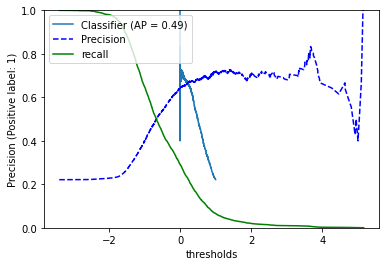

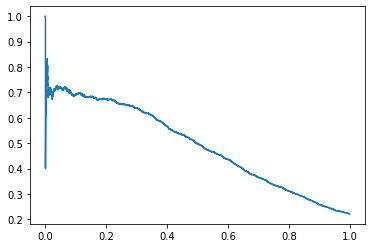

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
y_score = pipe.decision_function(X_train)
display = PrecisionRecallDisplay.from_predictions(y_train,y_score)
precisions , recalls , thresholds = precision_recall_curve(y_train, y_score)
precisions.shape
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-',label="recall")
    plt.xlabel("thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
plt.plot(recalls, precisions)
plt.show()